In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.optimize 
import warnings
import os

In [2]:
A_OPT = True # Generates a_opt vs theta Fig.
A_EQ = True  # Generates a_eq vs alpha Fig.
HMF = True
DBMF = True
R_INF = True # Generates r_inf vs alpha Fig.

$$s_{t+1} = s_t - \beta \langle k \rangle a_t s_t i_t$$
$$i_{t+1} = i_t + \beta \langle k \rangle a_t s_t i_t - \mu i_t$$
$$r_{t+1} = r_t + \mu i_t$$
$$a_{t+1} = \frac{1}{1 + \delta \beta \langle k \rangle a_t i_t \alpha_{tot}}$$

In [3]:
# Population

N_tot = int(100000)
i0 = 0.01
delta = 0.9

# Biological Parameters

mu = 0.1  # Recovery rate
R0 = 3.
beta_HMF = R0*mu # Technically it's beta*<k>

# CODE PARAMETERS

zero_tol = 1e-9  # value of i considered to be 0
t_max = 1000 # max lenght of simulations

# Colors
c1 = "#198ed5ff" # blue
c2 = "#b10d0dff" # red

# Range

alpha_grid = np.hstack((0,np.geomspace(0.1, 100, 20)))

In [4]:
alpha_grid

array([  0.        ,   0.1       ,   0.14384499,   0.20691381,
         0.29763514,   0.42813324,   0.61584821,   0.88586679,
         1.27427499,   1.83298071,   2.6366509 ,   3.79269019,
         5.45559478,   7.8475997 ,  11.28837892,  16.23776739,
        23.35721469,  33.59818286,  48.32930239,  69.51927962,
       100.        ])

In [5]:
def colorFader(c1, c2, opacity=1, mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    color1=np.array(mpl.colors.to_rgba(c1))
    color1[3] *= opacity
    color2=np.array(mpl.colors.to_rgba(c2))
    color2[3] *= opacity
    return mpl.colors.to_hex(mix*color1 + (1-mix)*color2, keep_alpha=True)

## Equivalent social activity

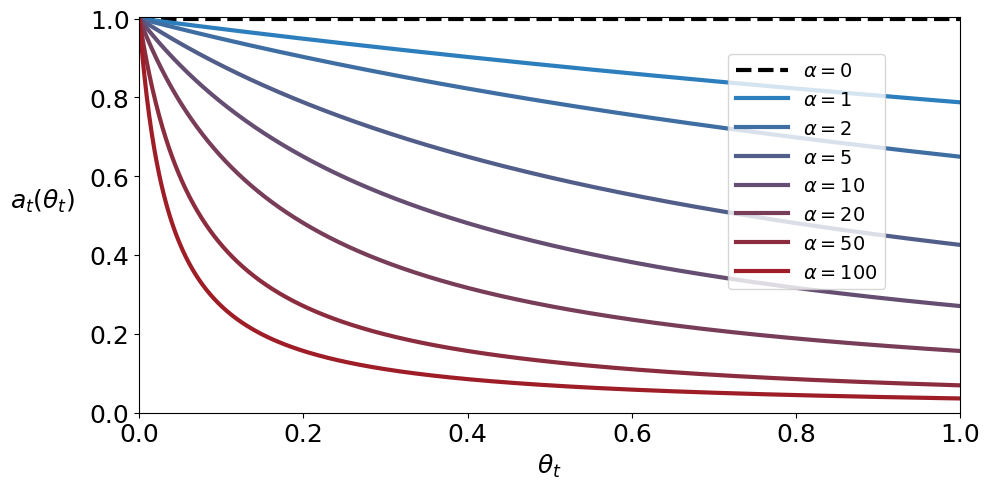

In [6]:
if A_OPT == True:
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    fontsize = 18

    ax.set_xlabel("$\\theta_t$", fontsize=fontsize)
    ax.set_ylabel("$a_t(\\theta_t)$", fontsize=fontsize, labelpad=34).set_rotation(0)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)

    alpha_list = np.array([0, 1, 2, 5, 10, 20, 50, 100])

    thetas = np.linspace(0, 1, 1000)

    for idx, alpha in enumerate(alpha_list):

        a_list = [1 / (1 + delta*alpha*beta_HMF*theta) for theta in thetas]  

        if alpha == 0:
            linestyle = "dashed"
            color = "black"
            label = "$\\alpha = 0$"
        else:  
            linestyle = "solid"
            color = colorFader(c2, c1, 1, idx/len(alpha_list))
            label = "$\\alpha = {}$".format(alpha)

        linewidth = 3

        ax.plot(thetas, a_list, label = label, linestyle=linestyle,
                color=color, linewidth=linewidth)
        
    #ax.text(0.5, .8, "$\delta={}$".format(delta),
    #        horizontalalignment='center',
    #        color = "k",
    #        fontsize=24)    
    
    plt.xlim(0,1)
    plt.ylim(0,1.005)
    fig.legend(prop={'size': 14}, handlelength=2.66, bbox_to_anchor=(0.9, 0.9))
    plt.tight_layout()
    plt.savefig("../Figures/a_opt/a_opt.png")
    plt.show()

## Equivalent social activity

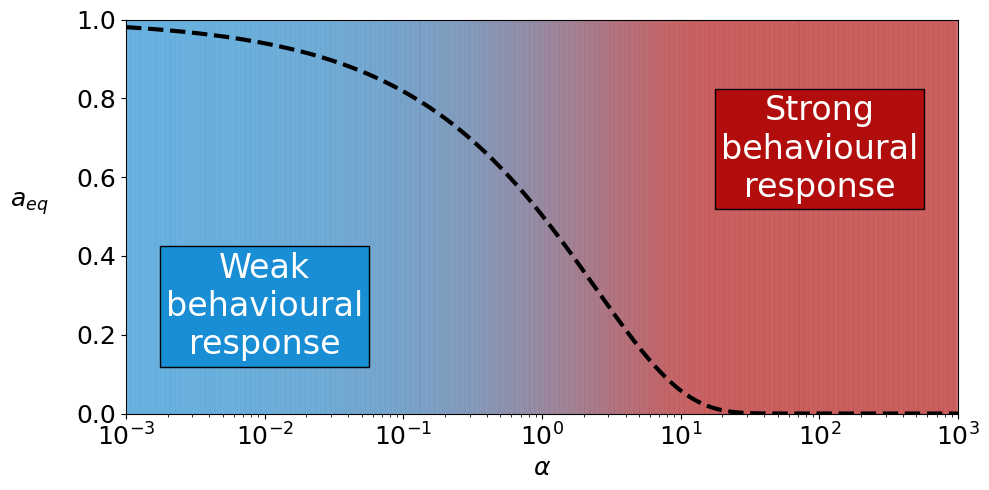

In [7]:
if A_EQ == True:

    def opt_fun(x, U_I):
        # Numerically find a_eq as the minimum of opt_fun
        return ( (np.log(x) - x + 1) + U_I)**2

    alpha_grid = np.geomspace(1e-3, 1e3, 1000)
    U_I_grid = (1-delta*(1-mu))*alpha_grid
    
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    fontsize = 18

    ax.set_xlabel("$\\alpha$", fontsize=fontsize)
    ax.set_ylabel(r"$a_{eq}$", fontsize=fontsize, labelpad=34).set_rotation(0)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)

    # Calculate with U_I but plot corresponding alpha
    a_equiv = [scipy.optimize.fminbound(opt_fun, x1=0, x2=1, args=[U_I], disp=False, xtol=1e-12) for U_I in U_I_grid]
    ax.plot(alpha_grid, a_equiv, color="k", linestyle="dashed", linewidth=3, zorder=1)

    for i,x in enumerate(alpha_grid):
        ax.axvline(x, color=colorFader(c1, c2, 0.15, a_equiv[i]), linewidth=4, zorder=0)

    ax.text(1e-2, .15, "Weak\nbehavioural\nresponse",
            horizontalalignment='center',
            color = "white",
            bbox=dict(facecolor=c1, alpha=1),
            fontsize=24)
    
    ax.text(1e2, .55, "Strong\nbehavioural\nresponse",
            horizontalalignment='center',
            color = "white",
            bbox=dict(facecolor=c2, alpha=1),
            fontsize=24)  

    plt.xscale("log")
    plt.xlim(min(alpha_grid), max(alpha_grid))
    plt.ylim(0, 1)
    #ax.legend(prop={'size': 18}, handlelength=2.66)

    plt.tight_layout()
    plt.savefig("../Figures/a_eq/a_eq.png")
    plt.show()

## HMF

In [8]:
def step_HMF(Y, beta, mu, a):
    # s = 1 - Y[0] -Y[1]
    # i = Y[0]
    # r = Y[1]
     
    di = beta*(1 - Y[0] - Y[1])*a*a*Y[0]
    dr = Y[0]*mu
    
    i_new = Y[0] +di - dr
    r_new = Y[1] +dr
    
    return np.array([i_new, r_new])

In [9]:
def simulate_HMF(t_max, beta, mu, alpha, i0):
    
    Y_list = []
    a_list = []
    
    eradicated = False

    tt = np.arange(0, t_max+1, 1)
    
    Y = np.array([i0, 0]) #initial condition Y[0] = i, Y[1] = r
    a = 1
    
    for idx, t in enumerate(tt):

        a = 1 / (1 + beta*alpha*a*Y[0])
        
        if Y[0] < zero_tol:
            # If I = 0 the epidemic is over
            eradicated = True
            tt = tt[0:idx]
            break
        else:
            Y_list.append(Y)
            a_list.append(a)
        
        Y = step_HMF(Y, beta, mu, a)
    
    Y_array = np.array(Y_list)
    a_time_series = np.array(a_list)
    
    time_series = {"s": 1 - Y_array[:,0] - Y_array[:,1],
                   "i": Y_array[:,0],
                   "r": Y_array[:,1]
                  }

    return tt, time_series, a_time_series, eradicated

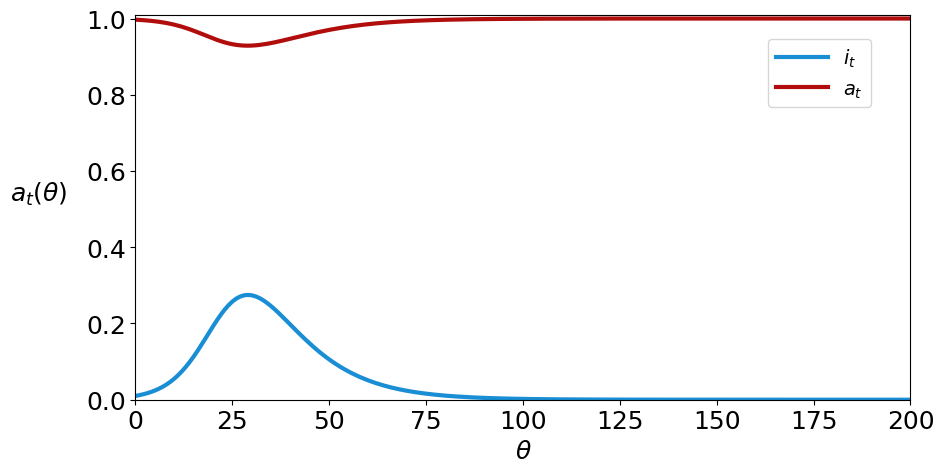

In [10]:
if HMF == True:

    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    fontsize = 18
    linewidth = 3

    ax.set_xlabel("$\\theta$", fontsize=fontsize)
    ax.set_ylabel("$a_t(\\theta)$", fontsize=fontsize, labelpad=34).set_rotation(0)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)

    tt, result, a, eradicated = simulate_HMF(t_max, beta_HMF, mu, 1, i0)

    plt.plot(tt, result["i"], color=c1, linewidth=linewidth, label="$i_t$")
    plt.plot(tt, a, color=c2, linewidth=linewidth, label="$a_t$")
    plt.xlim(0,200)
    plt.ylim(0,1.01)
    fig.legend(prop={'size': 14}, handlelength=2.66, bbox_to_anchor=(0.87, 0.85))

## DBMF

In [11]:
# (Annealed) network generation

k_min = 5                  # min degree
k_max = int(N_tot**(0.5))  # max degree
gamma = 2.1                # power law exponent p_k = C*k^{-gamma}

degrees = np.arange(k_min, k_max+1, 1)

p = {}

for k in degrees: 
    p[k] = np.array(k**(-gamma))

norm = sum([p[k] for k in degrees])

for k in degrees: 
    p[k] /= norm #normalize p_k

k_ave = sum([k * p[k] for k in degrees])
k_var = sum([k**2*p[k] for k in degrees])

beta_DBMF = mu*R0/k_ave
print("The average degree is: {}".format(k_ave))
print("The average transmission rate is: {}".format(beta_DBMF*k_ave))

The average degree is: 17.380457921965686
The average transmission rate is: 0.30000000000000004


In [12]:
def step_DBMF(Y, beta, mu, a, theta):
# Right-hand side of the differential eq. system
    
    di = np.array([beta*(1-Y[i]-Y[len(Y)//2+i])*degrees[i]*a[degrees[i]]*theta \
                   for i in range(0,len(Y)//2)])
    
    dr = np.array([mu*Y[i] for i in range(0,len(Y)//2)])
    
    dYdt = np.zeros(len(Y))
    dYdt[:len(Y)//2]  = +di - dr
    dYdt[len(Y)//2:]  = +dr
    
    return Y + dYdt

In [13]:
def simulate_DBMF(t_max, beta, mu, alpha, i0):
    
    Y_list = []
    a_list = []
    theta_list = []
    
    eradicated = False

    tt = np.arange(0, t_max+1, 1)
    
    init = np.zeros(2*len(degrees))   # indexes from 0 to len(degrees)-1 are for i_k,
                                      # indexes from len(degrees) to 2*len(degrees)-1 to are for r_k
    for k in degrees:
        init[k-k_min] = i0
        
    Y = np.array([elem for elem in init]) #initial conditions
    
    theta = sum([(k-1)*p[k]*Y[k-k_min]/k_ave for k in degrees]) # Density of infected neighbours
    # there is no a[k] in theta because at t=0 a[k] = 1
    
    a = {}
    for k in degrees:
        a[k] = 1
    
    a_time_series = {}
    for k in degrees:
        a_time_series[k] = []
    
    for idx, t in enumerate(tt):
        
        if all(Y[0:len(degrees)] < zero_tol):
            # If I = 0 the epidemic is over
            eradicated = True
            tt = tt[0:idx]
            break
        else:
            Y_list.append(Y)
            theta_list.append(theta)
            for k in degrees:
                a_time_series[k].append(a[k])
        
        for k in degrees:
            a[k] = 1 / (1 + alpha*delta*beta*k*theta)
        
        # Theta changes because of changes in a_k
        theta = sum([a[k]*(k-1)*p[k]*Y[k-k_min]/k_ave for k in degrees])
        
        Y = step_DBMF(Y, beta, mu, a, theta) # Advance
        
        # Theta changes because of changes in i_k
        theta = sum([a[k]*(k-1)*p[k]*Y[k-k_min]/k_ave for k in degrees])

    for k in degrees:
        a_time_series[k] = np.array(a_time_series[k])
            
    Y_array = np.array(Y_list)
    theta_time_series = np.array(theta_list)
    
    i_k = Y_array[:,0:len(degrees)]
    r_k = Y_array[:,len(degrees):]
    
    i_dict = {} 
    r_dict = {} 

    for k_idx, k in enumerate(degrees):
        i_dict[k] = i_k[:,k_idx]
        r_dict[k] = r_k[:,k_idx]

    time_series = {"i": i_dict,
                   "r": r_dict
                  }
    
    return tt, time_series, a_time_series, theta_time_series, eradicated # heterogeneous

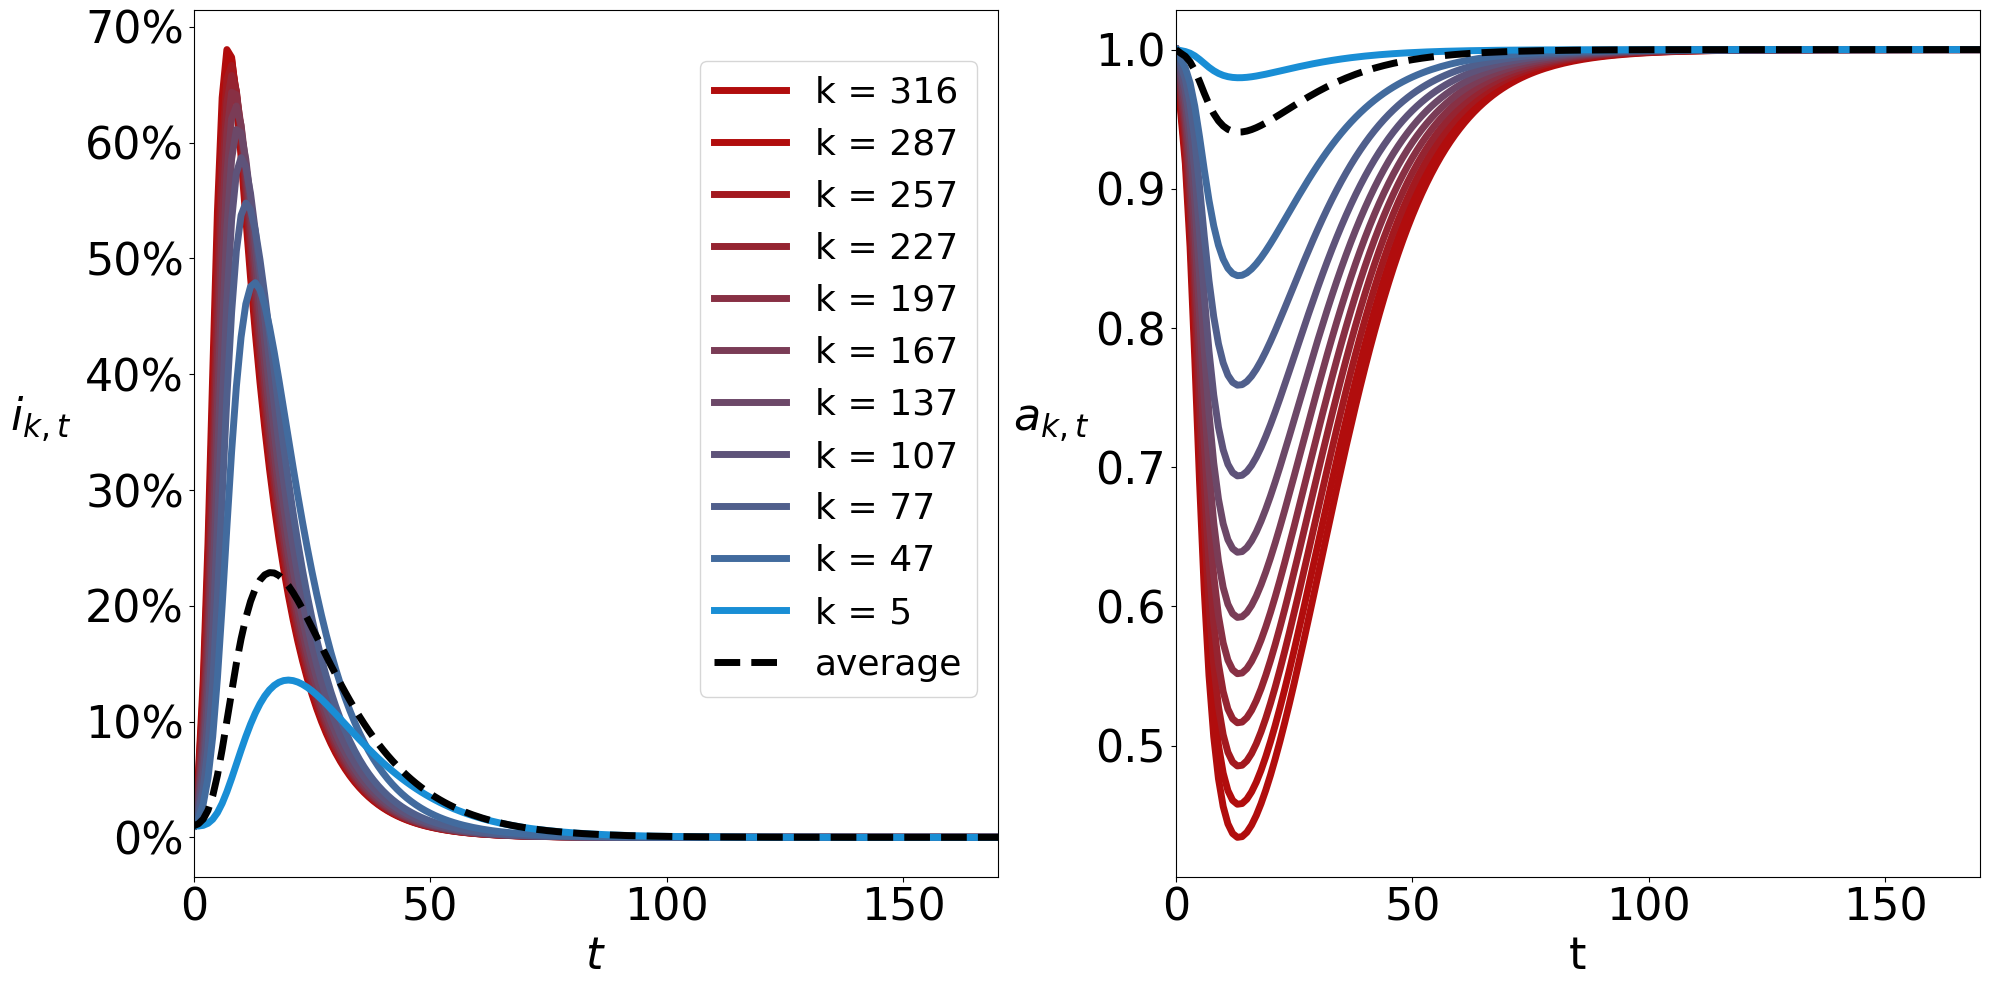

In [14]:
if DBMF == True:

    linewidth = 5

    fig, ax = plt.subplots(1,2, figsize=(20,10))

    fontsize = 32
    padsize = 32
    ticksize = 32

    ax1 = ax[0]
    ax2 = ax[1]

    ax1.set_xlabel('$t$', fontsize = fontsize)
    ax1.set_ylabel(r'$i_{k,t}$', fontsize = fontsize, labelpad=fontsize).set_rotation(0)
    ax1.tick_params(axis='y', labelsize=ticksize)
    ax1.tick_params(axis='x', labelsize=ticksize)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter()) #display "%" sign on y axis

    ax2.set_xlabel('t', fontsize = fontsize)
    ax2.set_ylabel(r'$a_{k,t}$', fontsize = fontsize, labelpad=fontsize).set_rotation(0)
    #ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)

    tt, result, a, theta, eradicated = simulate_DBMF(t_max, beta_DBMF, mu, 1, i0)

    if not eradicated:
        print("WARNING: tmax was reached")

    percent = {}

    for k_idx, k in enumerate(degrees):
        percent[k] = np.array([elem*100 for elem in result["i"][k]])  # Percentage of I

    kstep = 30

    ax1.plot(tt, percent[k_max], label="k = {}".format(k_max), color=c2, linewidth = linewidth) #Always display k_max
    ax2.plot(tt, a[k_max], color=c2, linestyle = "solid", linewidth = linewidth)
    for k_idx, k in enumerate(degrees[-kstep:kstep:-kstep]): # Plot only a fraction of all degrees
        color = colorFader(c1, c2, 1, k_idx/len(degrees[::-kstep]))
        ax1.plot(tt, percent[k], label="k = {}".format(k), color=color, linewidth = linewidth)
        ax2.plot(tt, a[k], color=color, linestyle = "solid", linewidth = linewidth)
    ax1.plot(tt, percent[k_min], label="k = {}".format(k_min), color=c1, linewidth = linewidth) #Always display k_min
    ax2.plot(tt, a[k_min], color=c1, linestyle = "solid", linewidth = linewidth)


    percent_tot = np.vstack(([np.pad(percent[k]*p[k],[(0, len(tt)-len(percent[k]))], mode='constant') # constant mode 
                          for k in degrees])).sum(axis=0)                                         # defaults to 0
    a_ave = np.vstack(([np.pad(a[k]*p[k],[(0, len(tt)-len(a[k]))], mode='constant')
                          for k in degrees])).sum(axis=0)

    ax1.plot(tt, percent_tot, color="k", linestyle = "dashed", linewidth = linewidth, label="average")  
    ax2.plot(tt, a_ave, color="k", linestyle = "dashed", linewidth = linewidth)

    fig.legend(bbox_to_anchor=(0.5, 0.95), prop={'size': 26})
    fig.tight_layout()  # otherwise the right y-label is slightly clipped   
    ax1.set_xlim(0, 170)
    ax2.set_xlim(0, 170)
    plt.show()

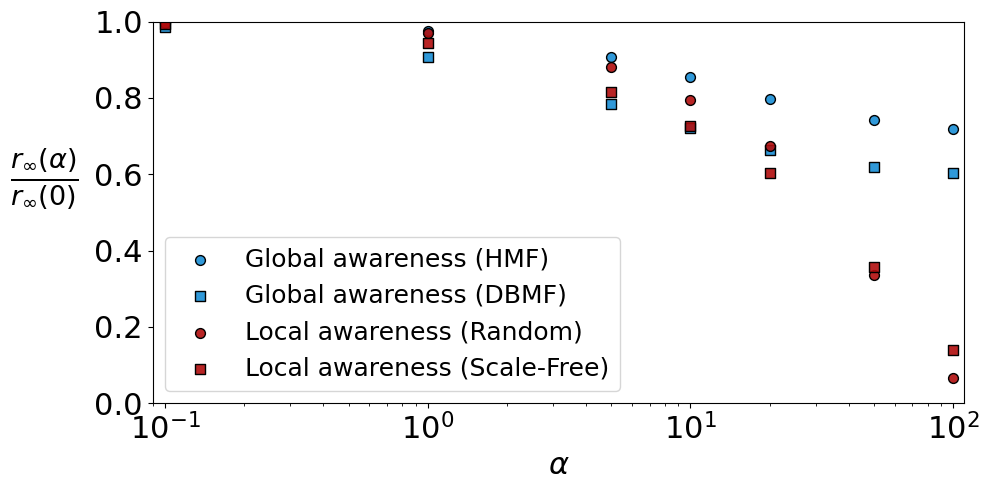

In [17]:
if R_INF == True:

    alpha_grid = []

    random_path = "../Data/RandomNetworkData/"
    scalefree_path = "../Data/ScaleFreeData/"

    for dirname in os.listdir(random_path):
        if os.path.isdir(random_path+dirname): # Check that it's actually a directory
            alpha_grid.append(float(dirname.replace("alpha=", "")))

    alpha_grid.sort()        
    alpha_grid = np.array(alpha_grid)

    fontsize = 22
    bigfontsize = 28
    linewidth = 1
    markersize = 50

    c1 = "#b10d0dff" # red
    c1_light = np.array(mpl.colors.to_rgba(c1))
    c1_light[3] *= 0.9
    c2 = "#198ed5ff" # blue
    c2_light = np.array(mpl.colors.to_rgba(c2))
    c2_light[3] *= 0.9

    plt.rcParams['legend.title_fontsize'] = 24

    fig, ax = plt.subplots(1,1, figsize=(10, 5))

    ax.set_xlabel('$\\alpha$', fontsize = fontsize)
    ax.set_ylabel(r'$\frac {{ r_{\infty}(\alpha) }}{{r_{\infty}(0)}}$', fontsize = bigfontsize, labelpad = 36).set_rotation(0)
    ax.tick_params(axis='both', which='both', labelsize = fontsize)      
    ax.set_xscale("log")
    #ax.yaxis.set_ticks([0, 0.5, 1])

    for idx, alpha in enumerate(alpha_grid):
        print("", end='\r')
        print(" Simulating alpha = {:.2f} ({}/{})".format(alpha, idx+1, len(alpha_grid)), end='\r')

        # HMF

        tt, result_HMF, a, eradicated = simulate_HMF(t_max, beta_HMF, mu, alpha, i0)

        if alpha == 0:
            r_inf_0_HMF = result_HMF["r"][-1]
            ax.scatter([],[], linewidth=linewidth,
                    facecolor=c2_light, marker = "o",
                    label="Global awareness (HMF)", s=markersize, edgecolor="k")
        else:
            ax.scatter(alpha, result_HMF["r"][-1]/r_inf_0_HMF,
                       linewidth=linewidth, facecolor=c2_light,
                       marker = "o", s=markersize,
                       edgecolor="k")

        # DBMF

        tt, result_DBMF, a, theta, eradicated = simulate_DBMF(t_max, beta_DBMF, mu, alpha, i0)

        res_i_tot = np.vstack(([np.pad(result_DBMF["i"][k]*p[k],[(0, len(tt)-len(result_DBMF["i"][k]))], mode='constant') # constant mode 
                          for k in degrees])).sum(axis=0)    # defaults to 0
        res_r_tot = np.vstack(([np.pad(result_DBMF["r"][k]*p[k],[(0, len(tt)-len(result_DBMF["r"][k]))], mode='constant') # constant mode 
                  for k in degrees])).sum(axis=0)

        if alpha == 0:
            r_inf_0_DBMF = res_r_tot[-1]
            ax.scatter([],[], facecolor=c2_light,
                       linewidth=linewidth, marker = "s",
                       label="Global awareness (DBMF)", s=markersize,
                       edgecolor="k")
        else:
            ax.scatter(alpha, res_r_tot[-1]/r_inf_0_DBMF,
                       linewidth=linewidth, facecolor=c2_light, marker = "s",
                       s=markersize, edgecolor="k")

        # Random Network

        r_inf = np.load(random_path+"/alpha="+str(alpha)+"/r_inf.npy")

        if alpha == 0:
            r_inf_0_random = np.mean(r_inf)
            ax.scatter([],[], facecolor=c1_light, marker = "o",
                    linewidth=linewidth, label="Local awareness (Random)",
                    s=markersize, edgecolor="k")
        else:
            ax.scatter(alpha, np.mean(r_inf)/r_inf_0_random,
                    linewidth=linewidth, facecolor=c1_light, marker = "o",
                    s=markersize, edgecolor="k")

        # Scale-Free Network

        r_inf = np.load(scalefree_path+"/alpha="+str(alpha)+"/r_inf.npy")

        if alpha == 0:
            r_inf_0_scalefree = np.mean(r_inf)
            ax.scatter([],[], facecolor=c1_light, marker = "s",
                    linewidth=linewidth, label="Local awareness (Scale-Free)",
                    s=markersize, edgecolor="k")
        else:
            ax.scatter(alpha, np.mean(r_inf)/r_inf_0_scalefree,
                    linewidth=linewidth, facecolor=c1_light,
                    marker = "s", s=markersize, edgecolor="k")

    alpha_min = min(alpha_grid)
    alpha_max = max(alpha_grid)

    ax.set_xlim(0.09, 1.1*alpha_max)
    ax.set_ylim(0, 1)

    ax.legend(prop={'size': 18}, fontsize='big')

    fig.tight_layout()
    #plt.savefig("../Figures/r_inf/r_inf.png")
    plt.show()